In [52]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np
from sagemaker.serializers import CSVSerializer
import warnings
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

warnings.filterwarnings('ignore')
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

'eu-west-2'

In [53]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [54]:
stores = transactions.merge(stores)

stores['date'] = pd.to_datetime(stores['date'])

pd.to_datetime(stores.index)
stores = stores.rename(columns={'date': 'dates'})
stores['month'] = stores['dates'].dt.month
stores['year'] = stores['dates'].dt.year
stores['week'] = stores['dates'].dt.week
stores['day'] = stores['dates'].dt.day
stores = stores.set_index('dates')
stores

,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2013-01-01,25,770,Salinas,Santa Elena,D,1,1,2013,1,1
2013-01-02,25,1038,Salinas,Santa Elena,D,1,1,2013,1,2
2013-01-03,25,887,Salinas,Santa Elena,D,1,1,2013,1,3
2013-01-04,25,1054,Salinas,Santa Elena,D,1,1,2013,1,4
2013-01-05,25,1355,Salinas,Santa Elena,D,1,1,2013,1,5
...,...,...,...,...,...,...,...,...,...,...
2017-08-11,52,2957,Manta,Manabi,A,11,8,2017,32,11
2017-08-12,52,2804,Manta,Manabi,A,11,8,2017,32,12
2017-08-13,52,2433,Manta,Manabi,A,11,8,2017,32,13


In [55]:
def find_missing_dates ():
    for i in stores['year'].unique():
        year = pd.DataFrame(stores[stores['year'] == i])
        start_date = i.astype(str) + '-01-01'
        end_date = i.astype(str) + '-12-30'
        missing = pd.date_range(start = start_date, end = end_date ).difference(year.index)
        print('missing from {} to {} is '.format(start_date, end_date), missing)

find_missing_dates()

missing from 2013-01-01 to 2013-12-30 is  DatetimeIndex(['2013-12-25'], dtype='datetime64[ns]', freq=None)
missing from 2014-01-01 to 2014-12-30 is  DatetimeIndex(['2014-12-25'], dtype='datetime64[ns]', freq=None)
missing from 2015-01-01 to 2015-12-30 is  DatetimeIndex(['2015-12-25'], dtype='datetime64[ns]', freq=None)
missing from 2016-01-01 to 2016-12-30 is  DatetimeIndex(['2016-01-01', '2016-01-03', '2016-12-25'], dtype='datetime64[ns]', freq=None)
missing from 2017-01-01 to 2017-12-30 is  DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', length=137, freq=None)


# EDA

In [56]:
corr = stores.corr()
corr

,store_nbr,transactions,cluster,month,year,week,day
store_nbr,1.000000,0.189311,-0.078323,0.003649,0.016848,0.004348,-0.000190
transactions,0.189311,1.000000,0.196014,0.037838,-0.037086,0.027368,-0.020544
cluster,-0.078323,0.196014,1.000000,-0.000089,-0.014887,-0.000467,0.000392
month,0.003649,0.037838,-0.000089,1.000000,-0.151364,0.977354,-0.008214
year,0.016848,-0.037086,-0.014887,-0.151364,1.000000,-0.151970,-0.011118
week,0.004348,0.027368,-0.000467,0.977354,-0.151970,1.000000,0.057576
day,-0.000190,-0.020544,0.000392,-0.008214,-0.011118,0.057576,1.000000


Text(0.5, 1.0, 'Correlation heatmap')

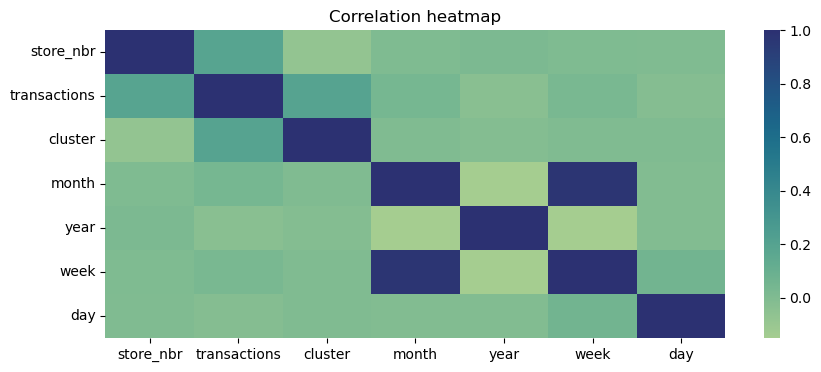

In [57]:
plt.figure(figsize=(10,4))
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

Text(0.5, 1.0, 'Distribution of transactions')

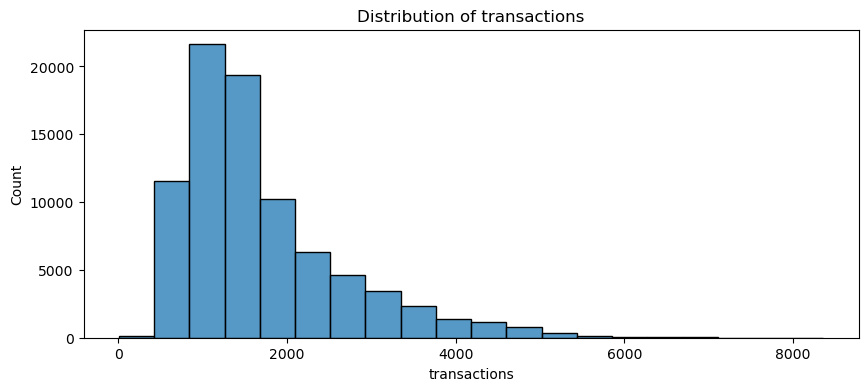

In [58]:
plt.figure(figsize=(10,4))
sns.histplot(stores['transactions'], bins=20)
plt.title('Distribution of transactions')

Text(0.5, 1.0, 'Transactions by city')

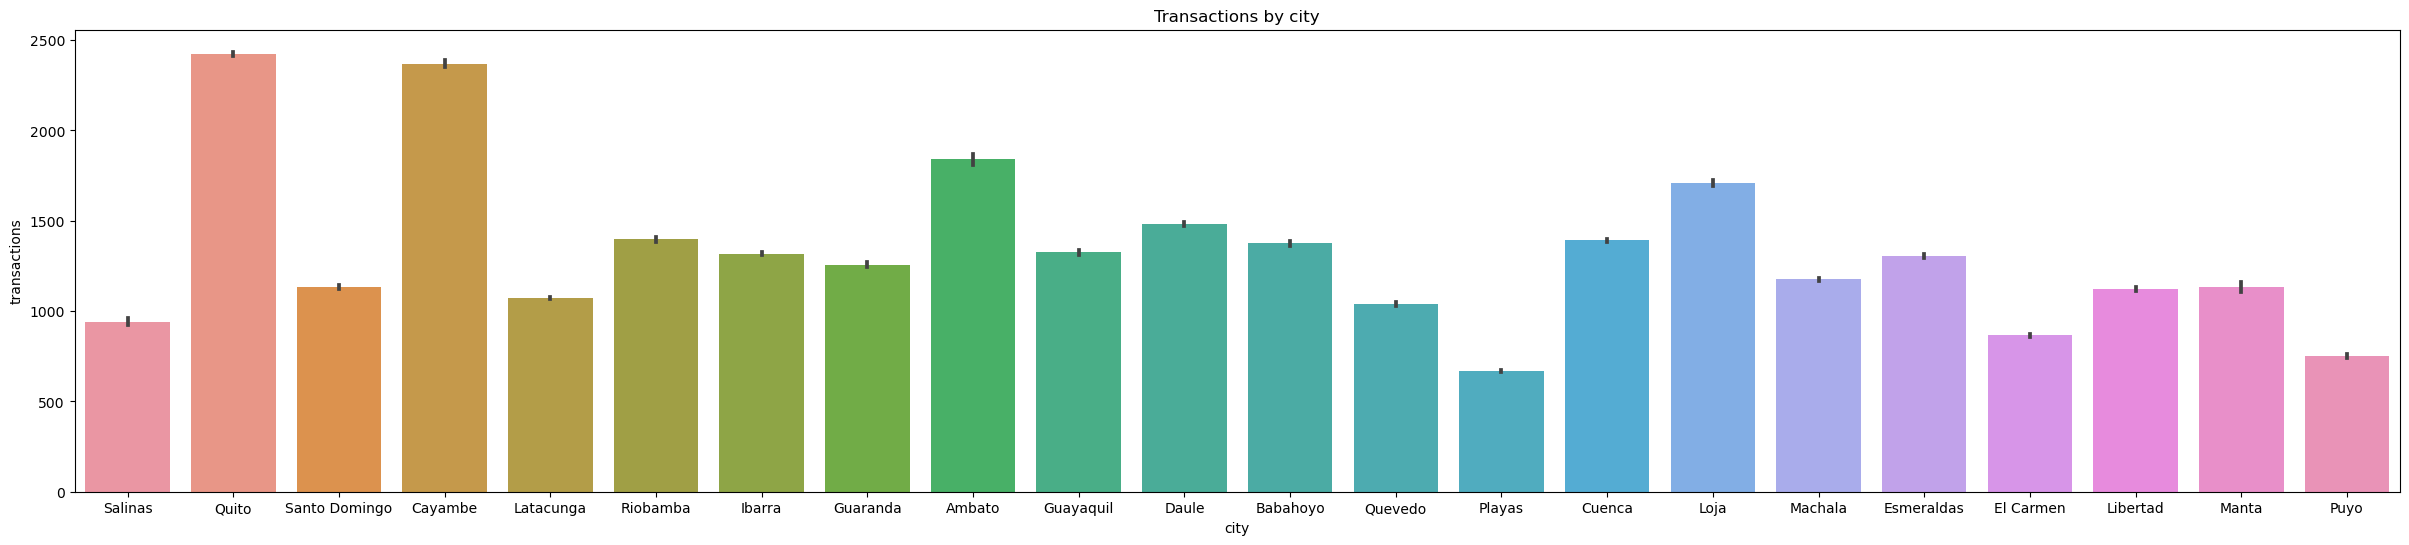

In [59]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='city', y='transactions')
plt.title('Transactions by city')

Text(0.5, 1.0, 'Transaction by state')

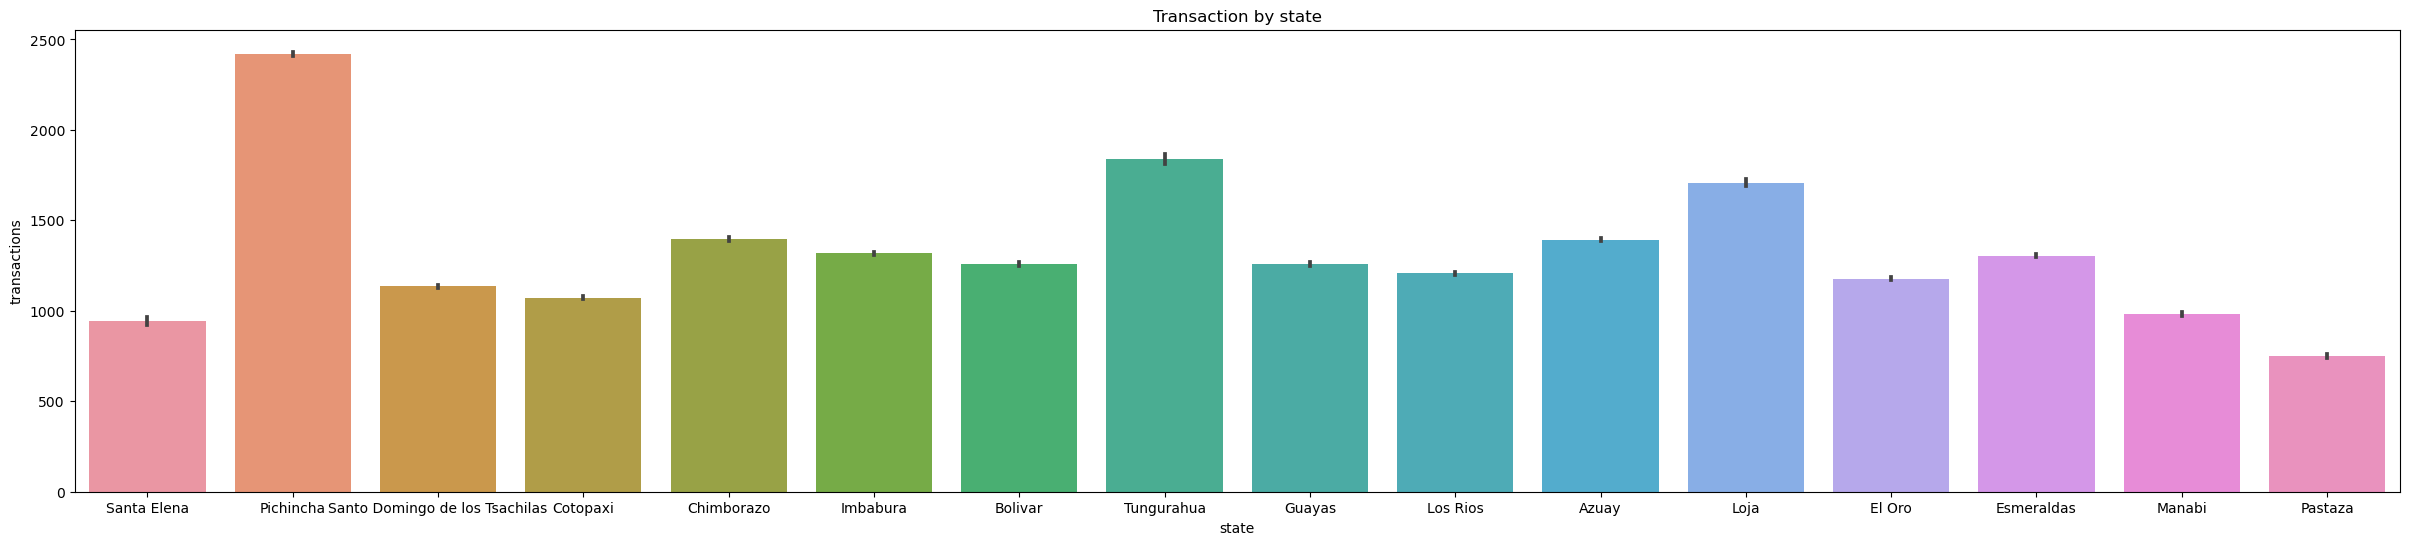

In [60]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='state', y='transactions')
plt.title('Transaction by state')

Text(0.5, 1.0, 'Transaction by year')

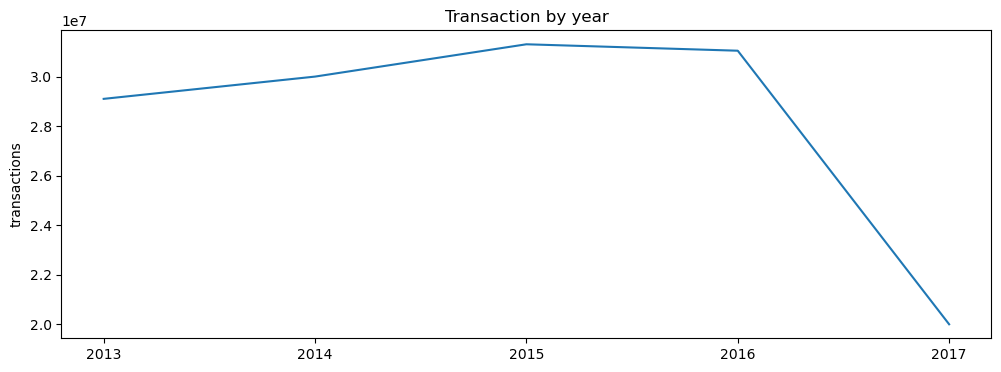

In [61]:
plt.figure(figsize=(12,4))

months = stores.month.unique()

transaction_per_week = stores.groupby('week')['transactions'].sum()
transaction_per_month = stores.groupby('month')['transactions'].sum()
transaction_per_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transaction by year')

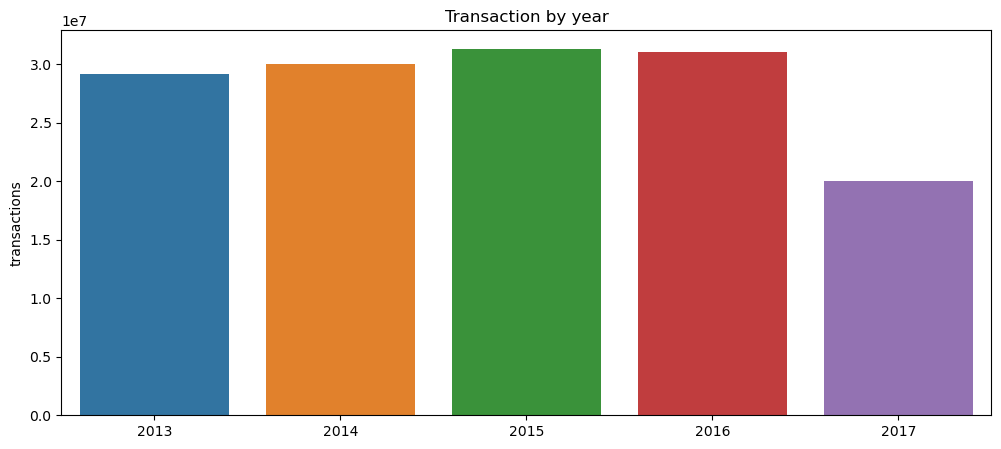

In [62]:
plt.figure(figsize=(12,5))

sns.barplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transaction by month')

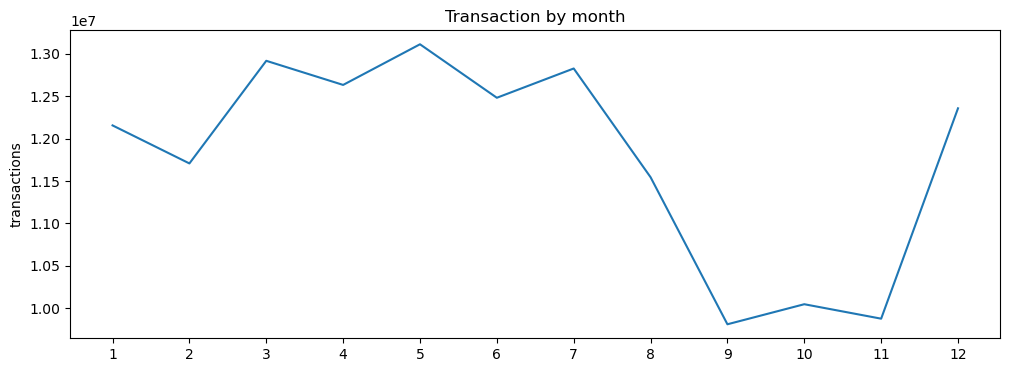

In [63]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by month')

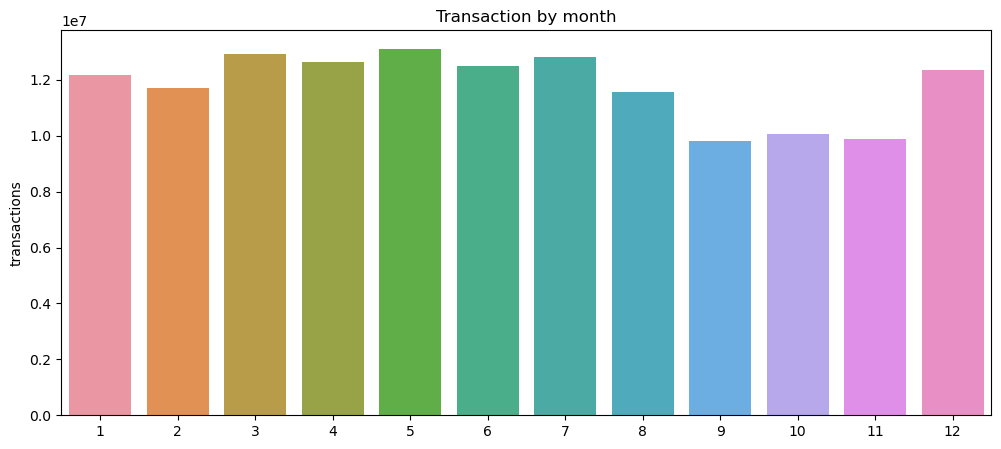

In [64]:
plt.figure(figsize=(12,5))
sns.barplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by week')

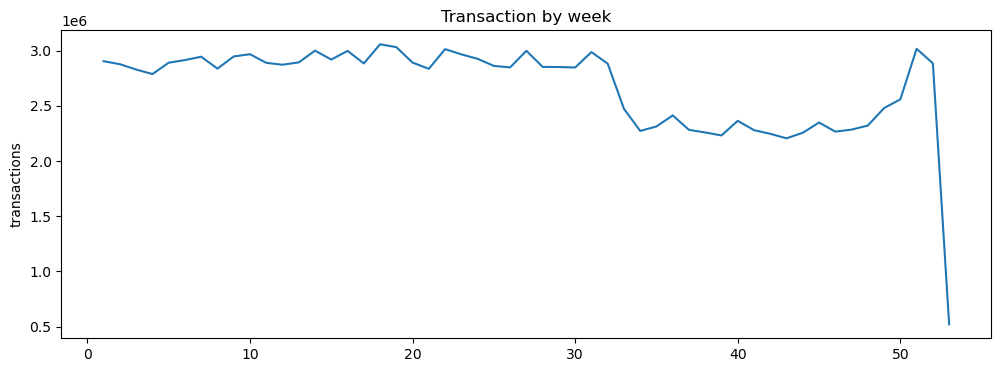

In [65]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['week'].unique(), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by week')

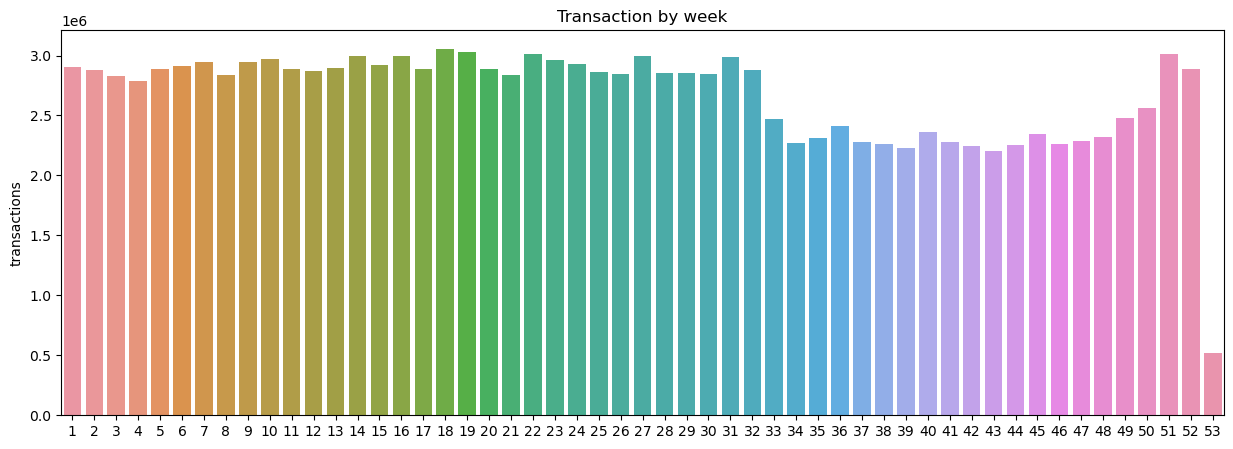

In [66]:
plt.figure(figsize=(15,5))

sns.barplot(x=stores['week'].unique().astype(str), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by year')

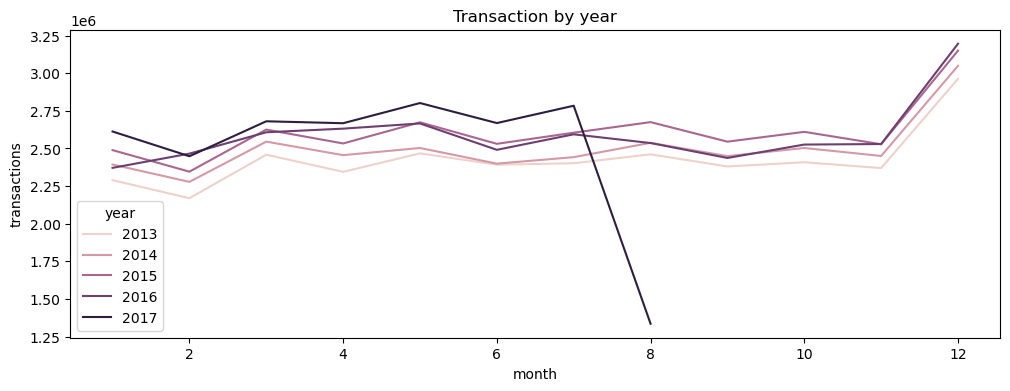

In [67]:
plt.figure(figsize=(12,4))
transactions_per_year = stores.groupby(['year','month'])['transactions'].sum()
transactions_per_year = pd.DataFrame(transactions_per_year)
transactions_per_year = transactions_per_year.reset_index()

sns.lineplot(data=transactions_per_year, x=transactions_per_year['month'], y=transactions_per_year['transactions'],hue=transactions_per_year['year'])
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transactions in 2015')

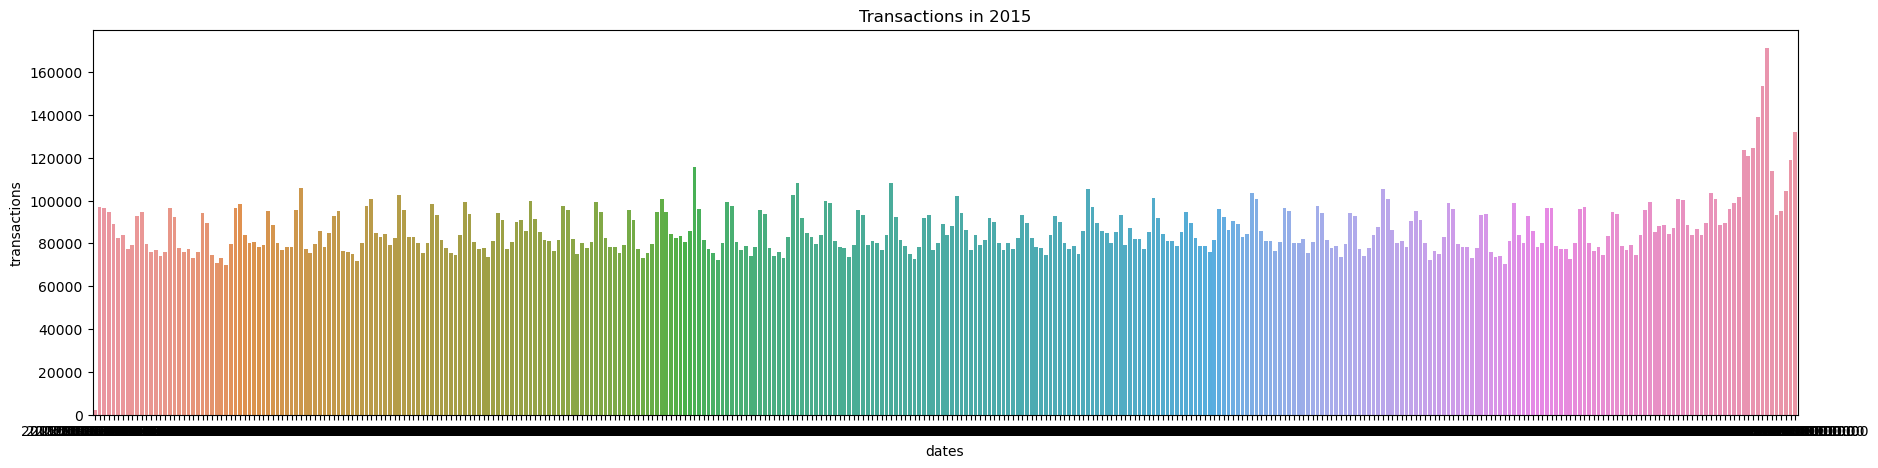

In [68]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2015]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2015')

Text(0.5, 1.0, 'Transactions in 2016')

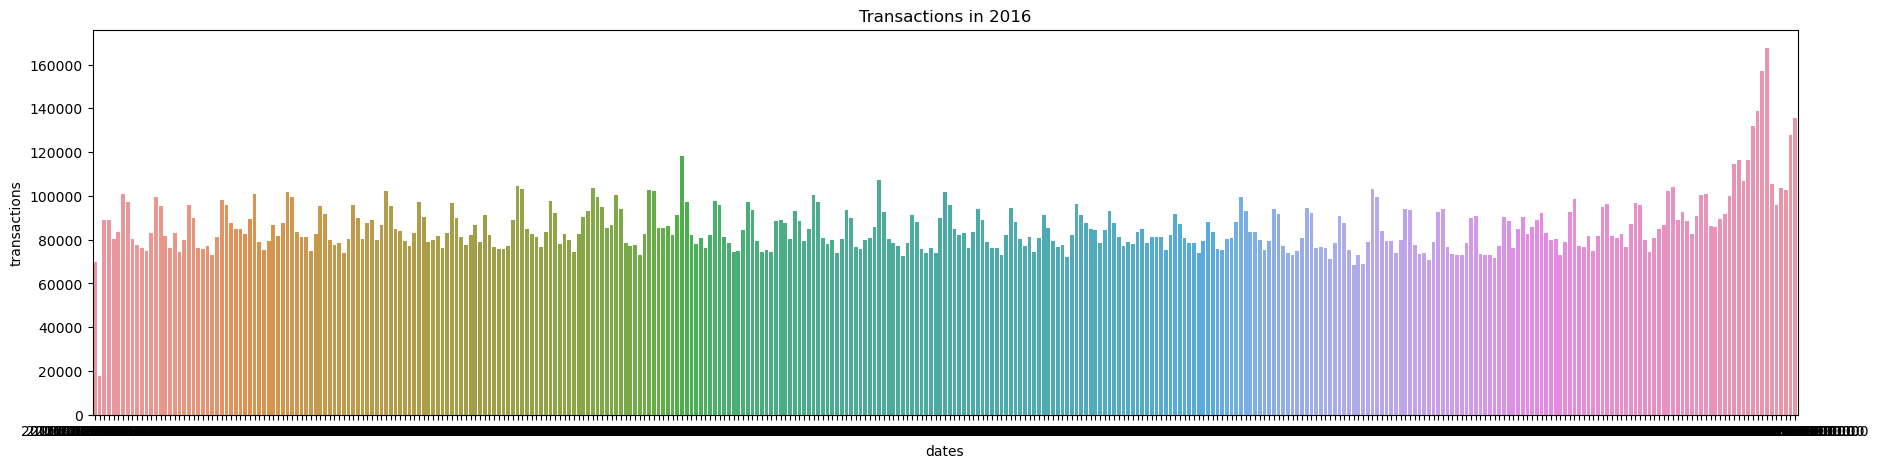

In [69]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

Text(0.5, 1.0, 'Transactions in 2016')

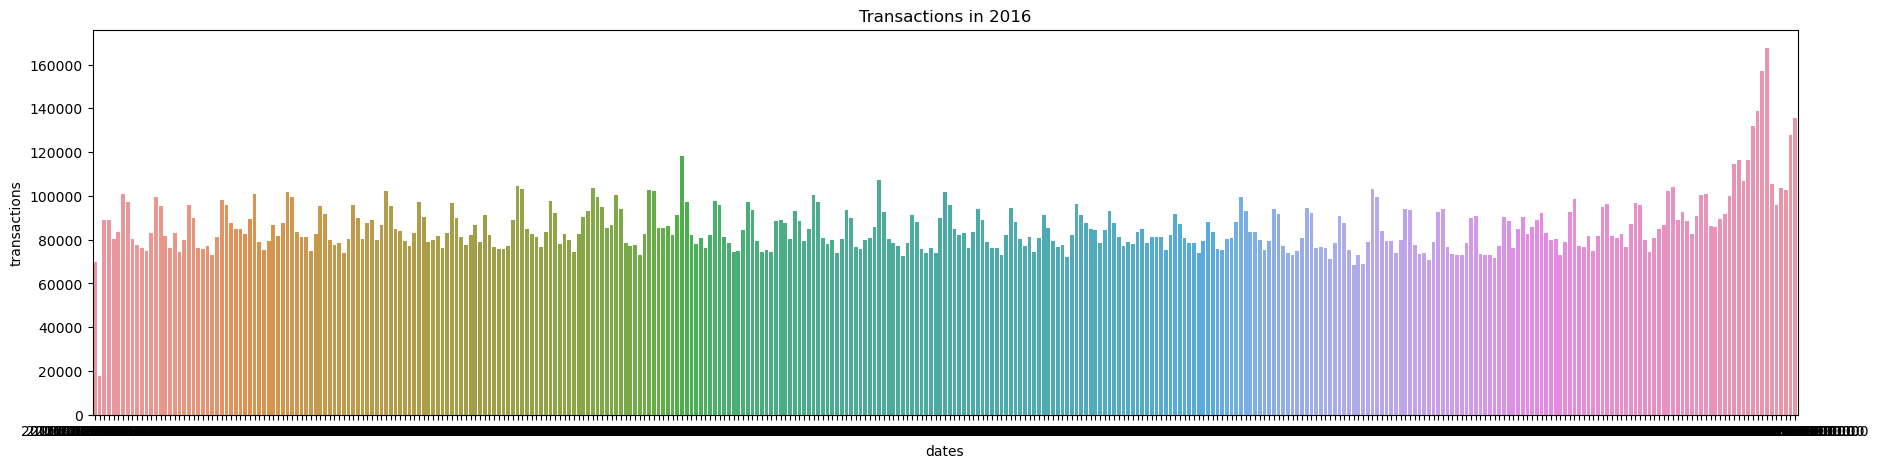

In [70]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

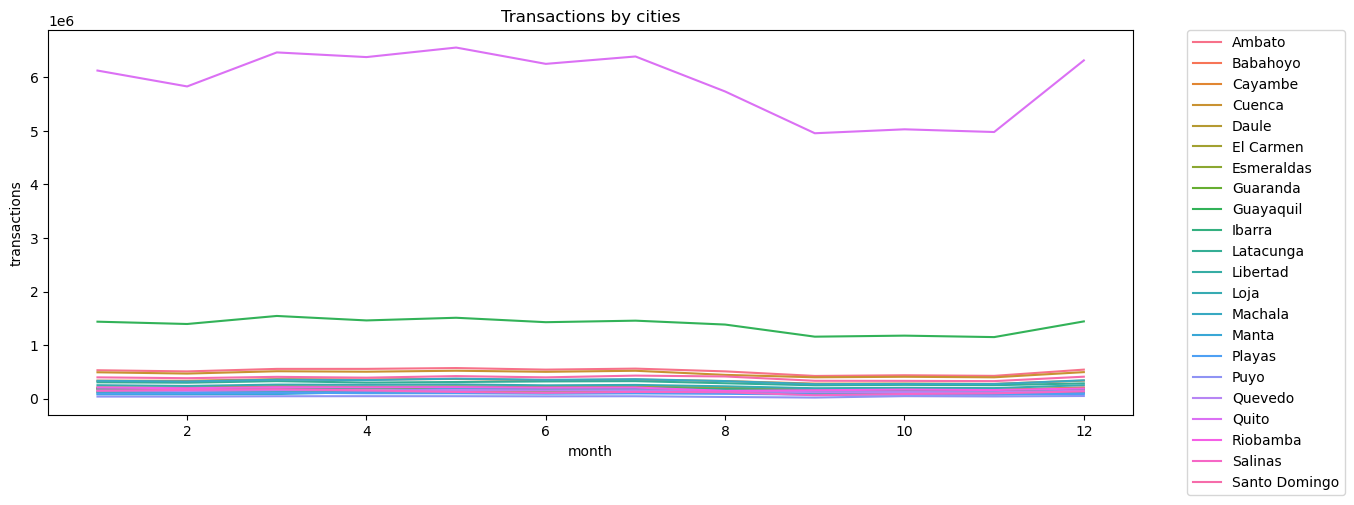

In [71]:
stores['cities'] = stores['city']
city_by_month = stores.groupby(['cities', 'month'])['transactions'].sum()
city_by_month = pd.DataFrame(city_by_month)
city_by_month = city_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=city_by_month, x=city_by_month['month'], y=city_by_month['transactions'], hue=city_by_month['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by cities')
stores = stores.drop('cities', axis=1)

Text(0.5, 1.0, 'Count of transactions by cities')

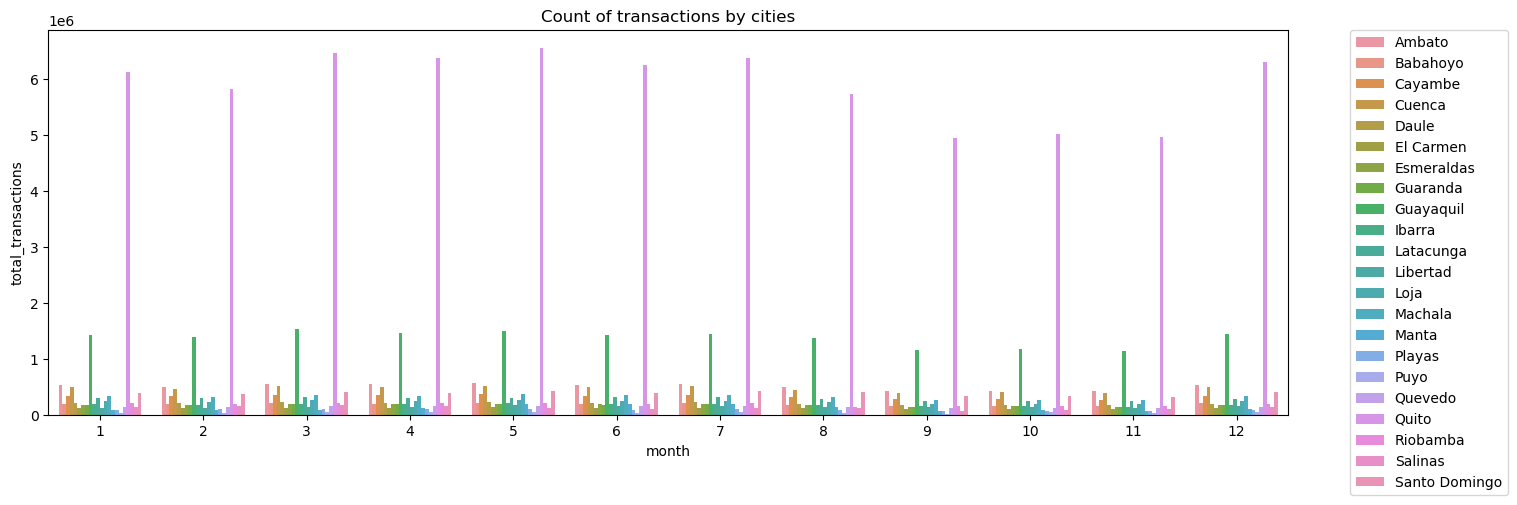

In [72]:
stores['cities'] = stores['city']
city_by_month_count = stores.groupby(['cities', 'month'])['transactions'].count()
city_by_month_count = pd.DataFrame(city_by_month_count)
city_by_month_count = city_by_month_count.reset_index()
city_by_month_count['total_transactions'] = city_by_month['transactions']

plt.figure(figsize=(16,5))
sns.barplot(data=city_by_month_count, x=city_by_month_count['month'], y=city_by_month_count['total_transactions'], hue=city_by_month_count['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Count of transactions by cities')

Text(0.5, 1.0, 'Transactions by type')

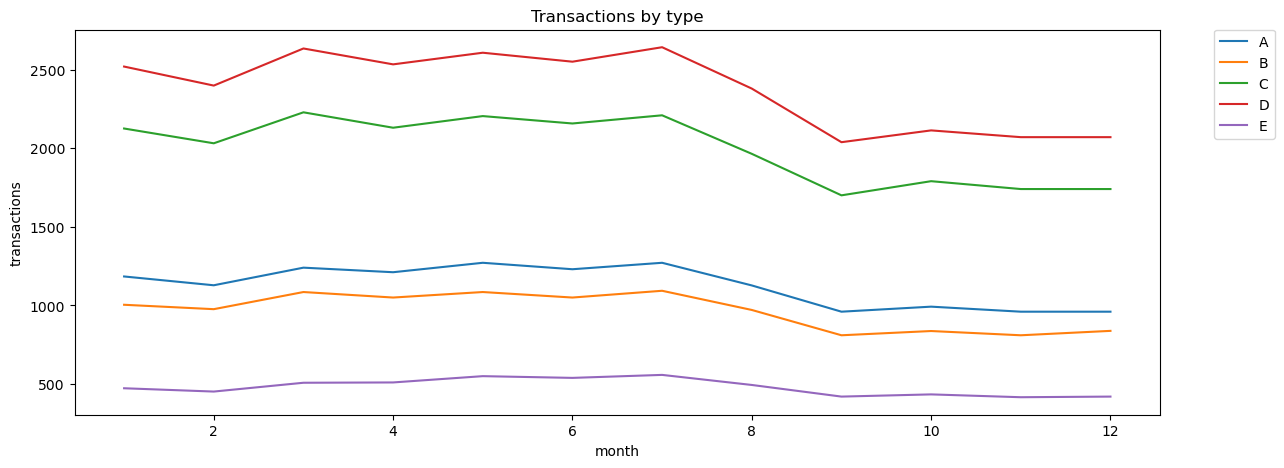

In [73]:
type_by_month = stores.groupby(['type', 'month'])['transactions'].count()
type_by_month = pd.DataFrame(type_by_month)
type_by_month = type_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=type_by_month, x=type_by_month['month'], y=type_by_month['transactions'], hue=type_by_month['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by type')

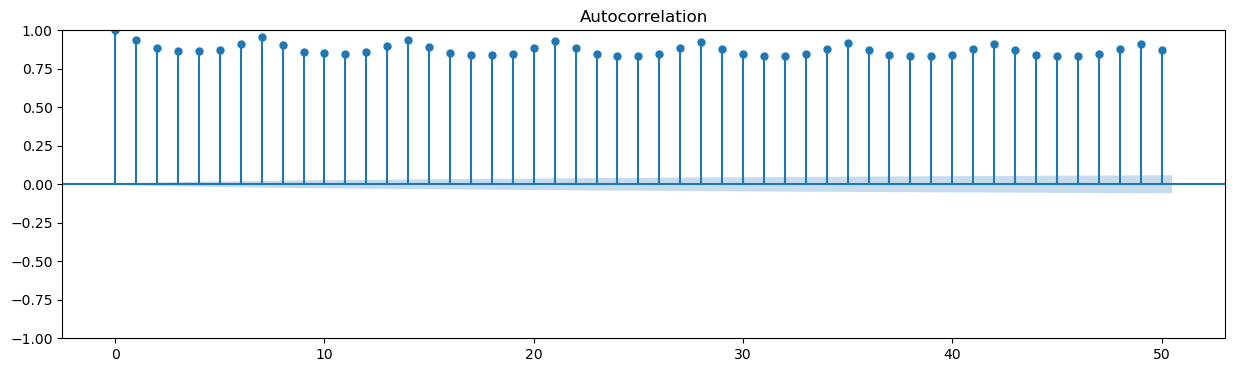

In [74]:
fig, ax = plt.subplots(figsize=(15,4))
to_plot = pd.DataFrame(stores['transactions'])
to_plot = to_plot.dropna()
acf = plot_acf(to_plot, lags=50,ax=ax)

# Cleaning

In [80]:
missing = pd.date_range(start="2013-01-01", end="2017-12-25")
missing = pd.DataFrame(missing, columns=['dates'])
stores = pd.merge(stores, missing, how="outer", on=['dates'])
stores = stores.sort_values('dates')
stores['month'] = stores['dates'].dt.month
stores['year'] = stores['dates'].dt.year
stores['week'] = stores['dates'].dt.week
stores['day'] = stores['dates'].dt.day
stores = stores.set_index('dates')

In [81]:
total_transactions_beyond_month_7 = stores[(stores['month'] > 7)
                                     & (stores['year'] == 2017)
                                     & (stores['day'] > 15)]
months = stores[stores['month'] > 7]
len_of_months = len(months)
nans = total_transactions_beyond_month_7[total_transactions_beyond_month_7['transactions'].isna()]
len_of_nans = len(nans)
total_transactions = months['transactions'].sum()
average = total_transactions/len_of_months


stores.loc[(stores['month'] > 7)
           & (stores['year'] == 2017)
           & (stores['day'] > 15), 'transactions'] = average


#stores[(stores['year'] == 2017) & (stores['month'] > 7)].sum()
stores

,store_nbr,transactions,city,state,type,cluster,month,year,week,day,cities
dates,,,,,,,,,,,
2013-01-01,25.0,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1,Salinas
2013-01-02,1.0,2111.000000,Quito,Pichincha,D,13.0,1,2013,1,2,Quito
2013-01-02,2.0,2358.000000,Quito,Pichincha,D,13.0,1,2013,1,2,Quito
2013-01-02,3.0,3487.000000,Quito,Pichincha,D,8.0,1,2013,1,2,Quito
2013-01-02,4.0,1922.000000,Quito,Pichincha,D,9.0,1,2013,1,2,Quito
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,NaN,1723.858502,NaN,NaN,NaN,NaN,12,2017,51,21,NaN
2017-12-22,NaN,1723.858502,NaN,NaN,NaN,NaN,12,2017,51,22,NaN
2017-12-23,NaN,1723.858502,NaN,NaN,NaN,NaN,12,2017,51,23,NaN


In [83]:
stores = stores.interpolate(method ='linear')
stores['city'] = stores['city'].interpolate(method ='ffill')
stores['state'] = stores['state'].interpolate(method ='ffill')
stores['type'] = stores['type'].interpolate(method ='ffill')

stores['transactions'].isna().sum()

0

In [84]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)
stores

,transactions,city,state,type,cluster,month,year,week,day,cities
dates,,,,,,,,,,
2013-01-01,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1,Salinas
2013-01-02,2111.000000,Quito,Pichincha,D,13.0,1,2013,1,2,Quito
2013-01-02,2358.000000,Quito,Pichincha,D,13.0,1,2013,1,2,Quito
2013-01-02,3487.000000,Quito,Pichincha,D,8.0,1,2013,1,2,Quito
2013-01-02,1922.000000,Quito,Pichincha,D,9.0,1,2013,1,2,Quito
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1723.858502,Guaranda,Bolivar,C,15.0,12,2017,51,21,NaN
2017-12-22,1723.858502,Guaranda,Bolivar,C,15.0,12,2017,51,22,NaN
2017-12-23,1723.858502,Guaranda,Bolivar,C,15.0,12,2017,51,23,NaN


In [85]:
target_map = stores['transactions'].to_dict()
stores['lag1'] = (stores.index - pd.Timedelta('364 days')).map(target_map)
stores['lag2'] = (stores.index - pd.Timedelta('728 days')).map(target_map)
stores['lag3'] = (stores.index - pd.Timedelta('1092 days')).map(target_map)

In [86]:
city = pd.get_dummies(stores['city'])
types = pd.get_dummies(stores['type'])
cluster = pd.get_dummies(stores['cluster'])
states = pd.get_dummies(stores['state'])

stores = pd.concat([stores, city], axis=1)
stores = pd.concat([stores, types], axis=1)
stores = pd.concat([stores, cluster], axis=1)
stores = pd.concat([stores, states], axis=1)

stores = stores.drop(stores[stores['year'] == 2017].index)
stores = stores.drop(['city', 'state', 'type', 'cluster', 'cities', 'week'], axis=1)
stores

,transactions,month,year,day,lag1,lag2,lag3,Ambato,Babahoyo,Cayambe,...,Guayas,Imbabura,Loja,Los Rios,Manabi,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Tungurahua
dates,,,,,,,,,,,,,,,,,,,,,
2013-01-01,770.0,1,2013,1,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-02,2111.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,2358.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,3487.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,1922.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,1826.0,12,2016,31,1099.0,1832.0,5600.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-31,1106.0,12,2016,31,1099.0,1832.0,5600.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2016-12-31,2232.0,12,2016,31,1099.0,1832.0,5600.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [87]:
y = stores['transactions']

train = stores.loc[stores.index < '2015-12-30']
test = stores.loc[stores.index >= '2015-12-30']
train

,transactions,month,year,day,lag1,lag2,lag3,Ambato,Babahoyo,Cayambe,...,Guayas,Imbabura,Loja,Los Rios,Manabi,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Tungurahua
dates,,,,,,,,,,,,,,,,,,,,,
2013-01-01,770.0,1,2013,1,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-02,2111.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,2358.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,3487.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-02,1922.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-29,1796.0,12,2015,29,998.0,3314.0,770.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-12-29,3577.0,12,2015,29,998.0,3314.0,770.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-12-29,2158.0,12,2015,29,998.0,3314.0,770.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [745]:
scaler = MinMaxScaler()

train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

x = train
x_test = test
y_test = test['transactions']
y_test = np.array(y_test)
x = scaler.fit_transform(x)
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))
train_set = pd.DataFrame(x)
test_set = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test, columns=['True'])

train_set.to_csv("train.csv", header=False, index=False)
test_set.to_csv("validation.csv", header=False, index=False)

In [750]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [747]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, '1.5-1')

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [ ]:
hyperparameters = {
    'max_depth': '5',
    'eta': '0.6',
    'verbosity': '0',
    'objective': 'reg:squarederror',
    'num_round' : 100,
    'eval_metric' : 'mae'
}

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
)

train_job = xgb.fit({"train": s3_input_train, "validation" : s3_input_validation})

In [523]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-04-07-08-46-39-166
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-04-07-08-46-39-166
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-04-07-08-46-39-166


------!

In [524]:
predictor.serializer = sagemaker.serializers.CSVSerializer()

In [749]:
true = np.array(y_test['True']).reshape(-1,1)
true = scaler.inverse_transform(true)

In [690]:
xgb.model_data

's3://sagemaker-eu-west-2-866647877267/Datasets/output/sagemaker-xgboost-2023-04-07-11-49-58-771/output/model.tar.gz'

In [541]:
def predict(data, predictor):
    split_array = np.array_split(data, int(data.shape[0] / float(500) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, predictor.predict(array).decode("utf-8")])
    return predictions.split("\n")[:-1]


predictions = predict(test_set.to_numpy()[:,1:], predictor)
predictions = [float(i) for i in predictions]
y_test['predicted'] = predictions

predicted = np.array(y_test['predicted']).reshape(-1,1)
predicted = scaler.inverse_transform(predicted)
result = pd.DataFrame(y_test)
result['predicted'] = predicted
result['True'] = true

result

,True,predicted
0,756.0,831.586150
1,1309.0,1642.677075
2,1667.0,1452.771455
3,1289.0,1465.509198
4,1472.0,1516.096586
...,...,...
19103,1478.0,879.314922
19104,2370.0,1854.553614
19105,2335.0,1403.636787
19106,1526.0,2157.986645


In [542]:
mape = mean_absolute_percentage_error(result['True'], result['predicted'])
mae = mean_absolute_error(result['True'], result['predicted'])

print("The mean absolute percentage error is {}".format(round(mape, 2)))
print("The mean absolute error is {}".format(round(mae,2)))

The mean absolute percentage error is 0.25
The mean absolute error is 338.53000000000003


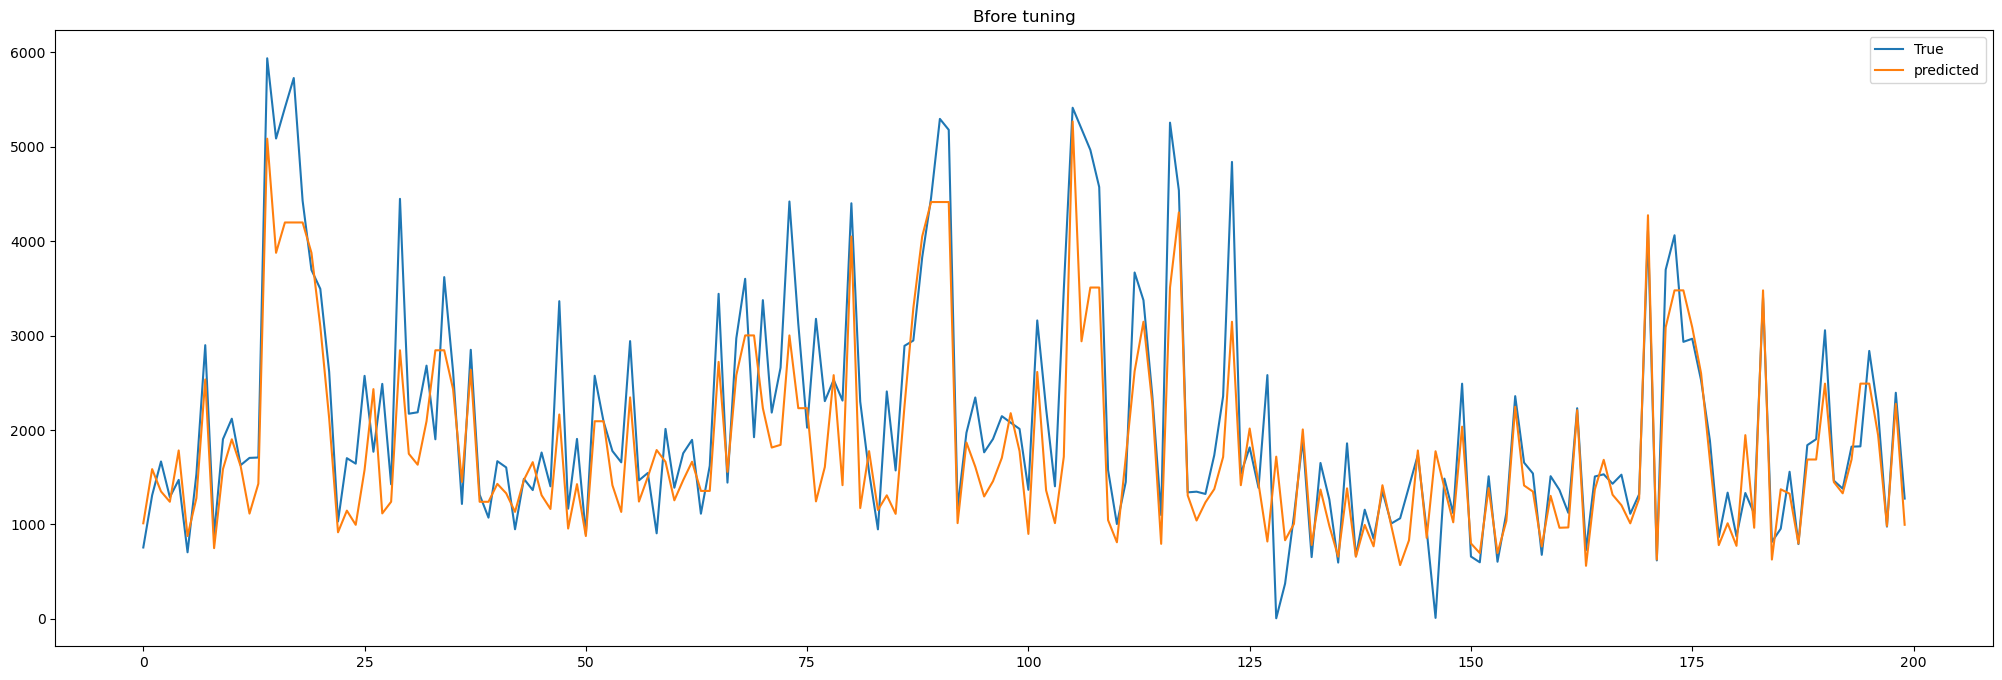

In [748]:
plt.figure(figsize=(25,8))
plt.plot(result['True'][:200], label='True')
plt.plot(result['predicted'][:200], label='predicted')
plt.legend()
plt.title('Bfore tuning')
plt.show()

In [696]:
n_jobs = 300
n_parallel_jobs = 10

hpt_ranges = {
    'eta': ContinuousParameter(0.2, 0.8),
    'num_round' : IntegerParameter(100, 1400),
    'max_depth' : IntegerParameter(2, 15),
    'colsample_bylevel' : ContinuousParameter(0.1, 1),
    'colsample_bytree' : ContinuousParameter(0.5, 1),
    'subsample' : ContinuousParameter(0.5, 1),
    'colsample_bynode' : ContinuousParameter(0.1, 1),
    'gamma' : IntegerParameter(0, 600),
    'min_child_weight' : ContinuousParameter(0,120)
}

tuner_parameters = {
    'estimator': xgb, # The same estimator object we defined above
    'base_tuning_job_name': 'bayesian',
    'objective_metric_name': 'validation:mae',
    'objective_type': 'Minimize',
    'hyperparameter_ranges': hpt_ranges,
    'strategy': 'Bayesian',
    'max_jobs': n_jobs,
    'max_parallel_jobs': n_parallel_jobs,
}

In [697]:
tuner = HyperparameterTuner(**tuner_parameters, early_stopping_type='Auto')
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, wait=False)
tuner_name = tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {tuner_name}.')

INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-230407-1203


tuning job submitted: bayesian-230407-1203.


In [698]:
tuner.describe()['BestTrainingJob']

{'TrainingJobName': 'bayesian-230407-1203-183-d3069841',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/bayesian-230407-1203-183-d3069841',
 'CreationTime': datetime.datetime(2023, 4, 7, 12, 38, 1, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 4, 7, 12, 38, 8, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 4, 7, 12, 38, 45, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'colsample_bylevel': '0.2397389203696429',
  'colsample_bynode': '0.1529005850243455',
  'colsample_bytree': '0.7250936643288709',
  'eta': '0.24843203969483624',
  'gamma': '0',
  'max_depth': '10',
  'min_child_weight': '35.08959763284251',
  'num_round': '359',
  'subsample': '0.7320017150644107'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
  'Value': 0.03223999962210655},
 'ObjectiveStatus': 'Succeeded'}

In [ ]:
tuned_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [700]:
tuned_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [701]:
predictions = predict(test_set.to_numpy()[:,1:], tuned_predictor)
predictions = [float(i) for i in predictions]
y_test['predicted'] = predictions

predicted = np.array(y_test['predicted']).reshape(-1,1)
predicted = scaler.inverse_transform(predicted)
result = pd.DataFrame(y_test)
result['predicted'] = predicted
result['True'] = true

result

,True,predicted
0,756.0,1012.154923
1,1309.0,1585.881576
2,1667.0,1349.850026
3,1289.0,1240.155133
4,1472.0,1783.658332
...,...,...
19103,1478.0,1162.229691
19104,2370.0,1673.915193
19105,2335.0,1433.932858
19106,1526.0,2199.609923


In [702]:
mape = mean_absolute_percentage_error(result['True'], result['predicted'])
mae = mean_absolute_error(result['True'], result['predicted'])

print("The mean absolute percentage error is {}".format(round(mape, 2)))
print("The mean absolute error is {}".format(round(mae, 2)))

The mean absolute percentage error is 0.21
The mean absolute error is 267.63


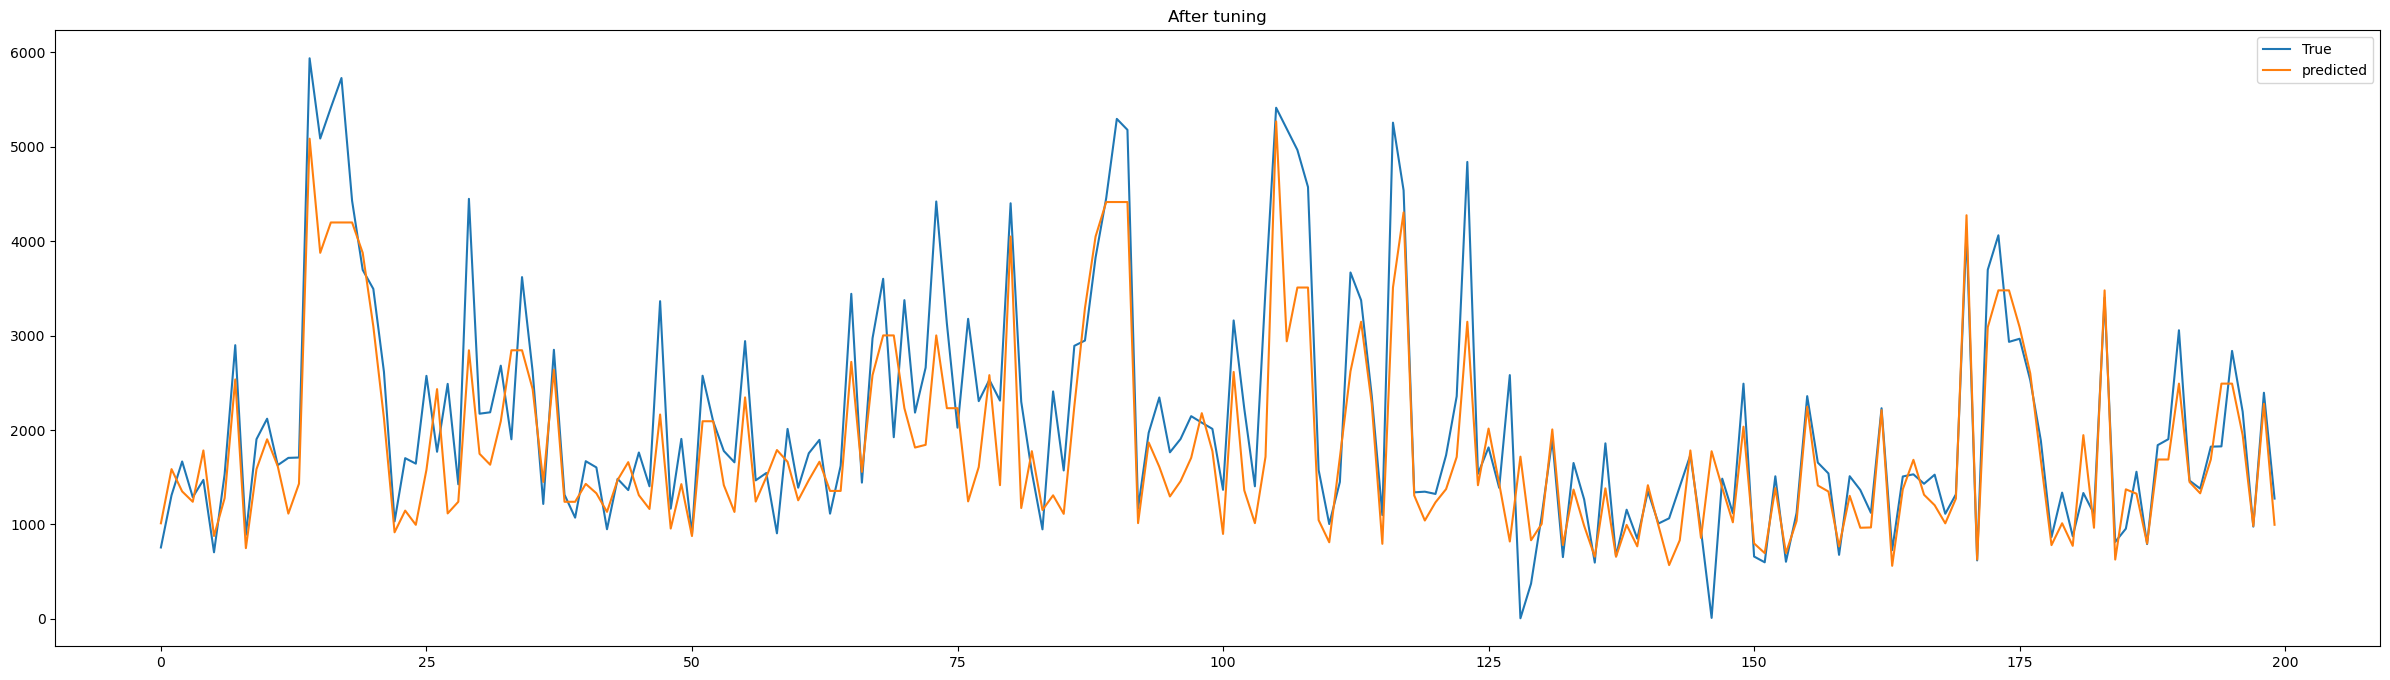

In [704]:
plt.figure(figsize=(30,8))
plt.plot(result['True'][:200], label='True')
plt.plot(result['predicted'][:200], label='predicted')
plt.legend()
plt.title('After tuning')
plt.show()